# Experiment: RNA All-Sample Clustering

Objective:
- Build a single RNA object from all available DBiT samples in `data-RNA`.
- Cluster all cells and save checkpointed outputs for reuse.


In [1]:
from __future__ import annotations

import importlib
from pathlib import Path

import anndata as ad
import pandas as pd
import scanpy as sc

import utils.dbit_rna_reader as dbit_rna_reader
from utils.plot_spatial_compact_fast import plot_spatial_compact_fast

dbit_rna_reader = importlib.reload(dbit_rna_reader)
discover_rna_tissue_pairs = dbit_rna_reader.discover_rna_tissue_pairs
write_rna_h5ad_per_sample = dbit_rna_reader.write_rna_h5ad_per_sample

sc.settings.verbosity = 2
sc.settings.set_figure_params(figsize=(5, 5), frameon=False)
print('scanpy:', sc.__version__)


scanpy: 1.11.5


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_17630/1612591833.py:19: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print('scanpy:', sc.__version__)


## Step 1 - Discover RNA Sample Pairs

Discover all `<sample>_RNA_matrix.csv.tar` + `<sample>_tissue_positions_list.csv.tar` pairs recursively under `data-RNA`.


In [3]:
data_root = Path('data-RNA/atac')
pairs = discover_rna_tissue_pairs(data_root, recursive=True)
required = {'RNA_matrix', 'tissue_positions_list'}
sample_ids = sorted([s for s, files in pairs.items() if required.issubset(files)])

if not sample_ids:
    raise RuntimeError(f'No complete RNA+tissue sample pairs found under {data_root}')

print('RNA samples discovered:', len(sample_ids))
sample_ids


RNA samples discovered: 7


['06_LPC5S1',
 '06_LPC5S2',
 '07_LPC10S1',
 '07_LPC10S2',
 '08_LPC21S1',
 '08_LPC21S2',
 'LPC5_Saggital']

## Step 2 - Checkpoint Per-Sample RNA h5ad

Write one `*.rna.h5ad` file per sample so reruns can resume quickly after crashes.


In [4]:
checkpoint_dir = Path('data/checkpoints')
rna_h5ad_dir = checkpoint_dir / 'rna_h5ad_by_sample'

RNA_OVERWRITE = False
rna_h5ad_manifest = write_rna_h5ad_per_sample(
    data_dir=data_root,
    out_dir=rna_h5ad_dir,
    sample_ids=sample_ids,
    overwrite=RNA_OVERWRITE,
    recursive=True,
)

print(rna_h5ad_manifest[['sample_id', 'status', 'n_obs', 'n_vars']])
rna_h5ad_manifest


       sample_id            status  n_obs  n_vars
0      06_LPC5S1  skipped_existing   8736   32285
1      06_LPC5S2  skipped_existing   8169   32285
2     07_LPC10S1  skipped_existing   8180   32285
3     07_LPC10S2  skipped_existing   8928   32285
4     08_LPC21S1  skipped_existing   8485   32285
5     08_LPC21S2  skipped_existing   8258   32285
6  LPC5_Saggital  skipped_existing   9403   32285


sample_id            status  \
0      06_LPC5S1  skipped_existing   
1      06_LPC5S2  skipped_existing   
2     07_LPC10S1  skipped_existing   
3     07_LPC10S2  skipped_existing   
4     08_LPC21S1  skipped_existing   
5     08_LPC21S2  skipped_existing   
6  LPC5_Saggital  skipped_existing   

                                            rna_h5ad  \
0  data/checkpoints/rna_h5ad_by_sample/06_LPC5S1....   
1  data/checkpoints/rna_h5ad_by_sample/06_LPC5S2....   
2  data/checkpoints/rna_h5ad_by_sample/07_LPC10S1...   
3  data/checkpoints/rna_h5ad_by_sample/07_LPC10S2...   
4  data/checkpoints/rna_h5ad_by_sample/08_LPC21S1...   
5  data/checkpoints/rna_h5ad_by_sample/08_LPC21S2...   
6  data/checkpoints/rna_h5ad_by_sample/LPC5_Saggi...   

                                          rna_tar  \
0      data-RNA/atac/06_LPC5S1_RNA_matrix.csv.tar   
1      data-RNA/atac/06_LPC5S2_RNA_matrix.csv.tar   
2     data-RNA/atac/07_LPC10S1_RNA_matrix.csv.tar   
3     data-RNA/atac/07_LPC10S2_RNA_matrix.csv.tar   
4     data-RNA/atac/08_LPC21S1_RNA_matrix.csv.tar   
5     data-RNA/atac/08_LPC21S2_RNA_matrix.csv.tar   
6  data-RNA/atac/LPC5_Saggital_RNA_matrix.csv.tar   

                                tissue_positions_tar  n_obs  n_vars  
0  data-RNA/atac/06_LPC5S1_tissue_positions_list....   8736   32285  
1  data-RNA/atac/06_LPC5S2_tissue_positions_list....   8169   32285  
2  data-RNA/atac/07_LPC10S1_tissue_positions_list...   8180   32285  
3  data-RNA/atac/07_LPC10S2_tissue_positions_list...   8928   32285  
4  data-RNA/atac/08_LPC21S1_tissue_positions_list...   8485   32285  
5  data-RNA/atac/08_LPC21S2_tissue_positions_list...   8258   32285  
6  data-RNA/atac/LPC5_Saggital_tissue_positions_l...   9403   32285

## Step 3 - Build One Combined RNA Object

Load all per-sample RNA checkpoints and concatenate into a single `AnnData`.


In [5]:
if 'rna_h5ad_manifest' not in globals():
    rna_h5ad_manifest = pd.DataFrame(
        {
            'sample_id': p.name.replace('.rna.h5ad', ''),
            'rna_h5ad': str(p),
            'status': 'existing',
        }
        for p in sorted((Path('data/checkpoints') / 'rna_h5ad_by_sample').glob('*.rna.h5ad'))
    )

samples_to_build = sorted(rna_h5ad_manifest['sample_id'].astype(str).tolist())
print('Building combined RNA from samples:', samples_to_build)

rna_parts = []
for sample_id in samples_to_build:
    row = rna_h5ad_manifest.loc[rna_h5ad_manifest['sample_id'].astype(str) == sample_id].iloc[0]
    a = sc.read_h5ad(str(row['rna_h5ad']))
    a.obs['sample_id'] = str(sample_id)
    if 'barcode' not in a.obs.columns:
        a.obs['barcode'] = a.obs_names.astype(str)
    a.obs['barcode'] = a.obs['barcode'].astype(str)
    a.obs_names = (a.obs['sample_id'] + ':' + a.obs['barcode']).to_numpy()
    a.obs_names_make_unique()
    rna_parts.append(a)

rna = ad.concat(rna_parts, join='outer', merge='first', fill_value=0)
print(rna)
rna


Building combined RNA from samples: ['06_LPC5S1', '06_LPC5S2', '07_LPC10S1', '07_LPC10S2', '08_LPC21S1', '08_LPC21S2', 'LPC5_Saggital']
AnnData object with n_obs × n_vars = 60159 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id'
    obsm: 'spatial'


AnnData object with n_obs × n_vars = 60159 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id'
    obsm: 'spatial'

## Step 4 - RNA Preprocessing and Clustering

Run a standard Scanpy pipeline for all RNA samples together.


In [6]:
rna_pp = rna.copy()
rna_pp.layers['counts'] = rna_pp.X.copy()

sc.pp.normalize_total(rna_pp)
sc.pp.log1p(rna_pp)
sc.pp.highly_variable_genes(rna_pp, min_mean=0.0125, max_mean=3.0, min_disp=0.5)

rna_pp.raw = rna_pp
rna_pp = rna_pp[:, rna_pp.var['highly_variable']].copy()

sc.pp.scale(rna_pp, max_value=10)
sc.tl.pca(rna_pp, svd_solver='arpack')
sc.pp.neighbors(rna_pp)
sc.tl.umap(rna_pp)
sc.tl.leiden(rna_pp, resolution=1.0, key_added='leiden_1')

print(rna_pp)
rna_pp


normalizing counts per cell


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:14)
computing UMAP
    finished (0:00:21)
running Leiden clustering


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_17630/1818140391.py:15: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_pp, resolution=1.0, key_added='leiden_1')


    finished (0:00:37)
AnnData object with n_obs × n_vars = 60159 × 2184
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id', 'leiden_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


AnnData object with n_obs × n_vars = 60159 × 2184
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_id', 'leiden_1'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

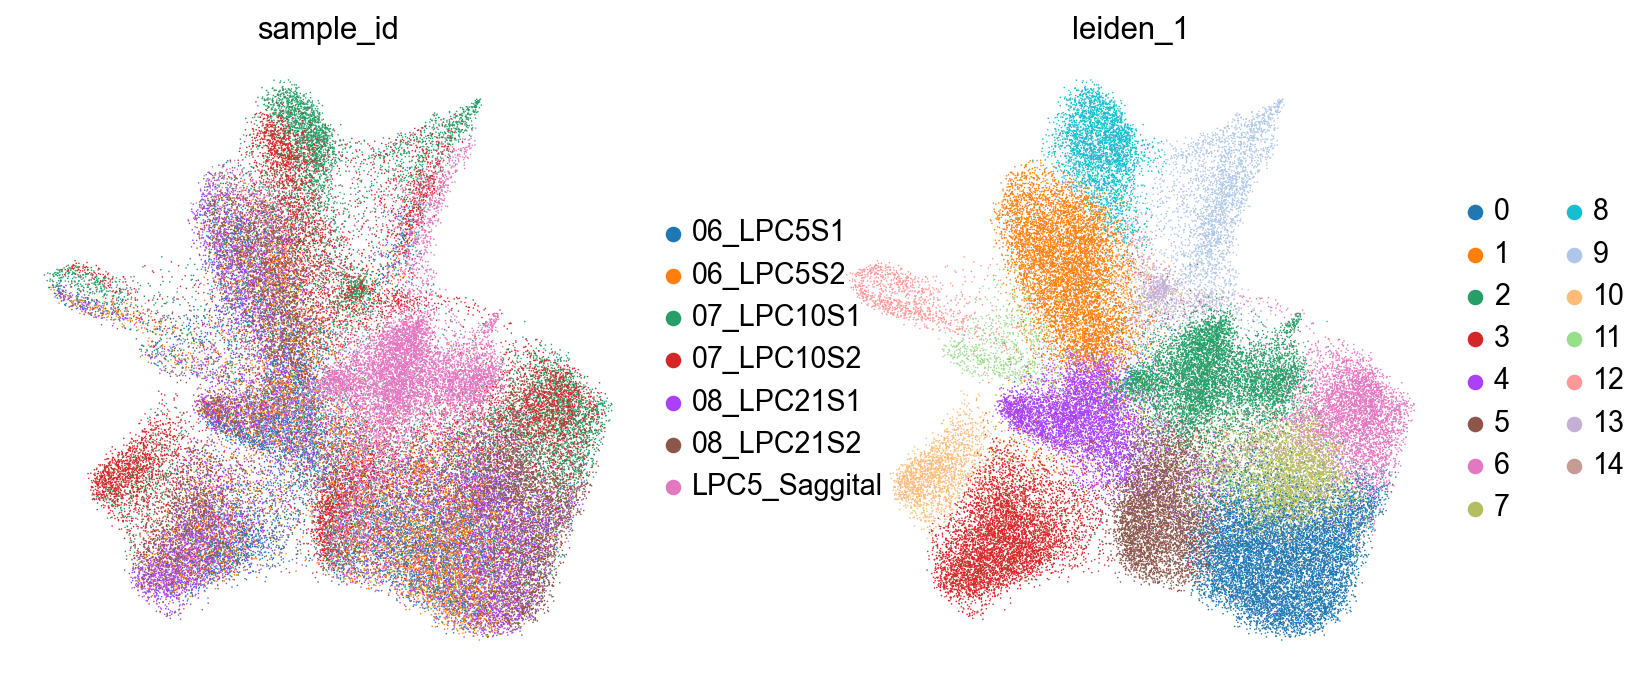

In [7]:
sc.pl.umap(rna_pp, color=['sample_id', 'leiden_1'])


## Step 5 - Optional Spatial Plot

Plot spatial clusters if `obsm['spatial']` is available.


/Users/christoffer/work/karolinska/Dbit-analysis/utils/plot_spatial_compact_fast.py:121: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col_series):
/Users/christoffer/work/karolinska/Dbit-analysis/utils/plot_spatial_compact_fast.py:206: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col_series):
/Users/christoffer/work/karolinska/Dbit-analysis/utils/plot_spatial_compact_fast.py:280: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(gser) and gser.cat.ordered:


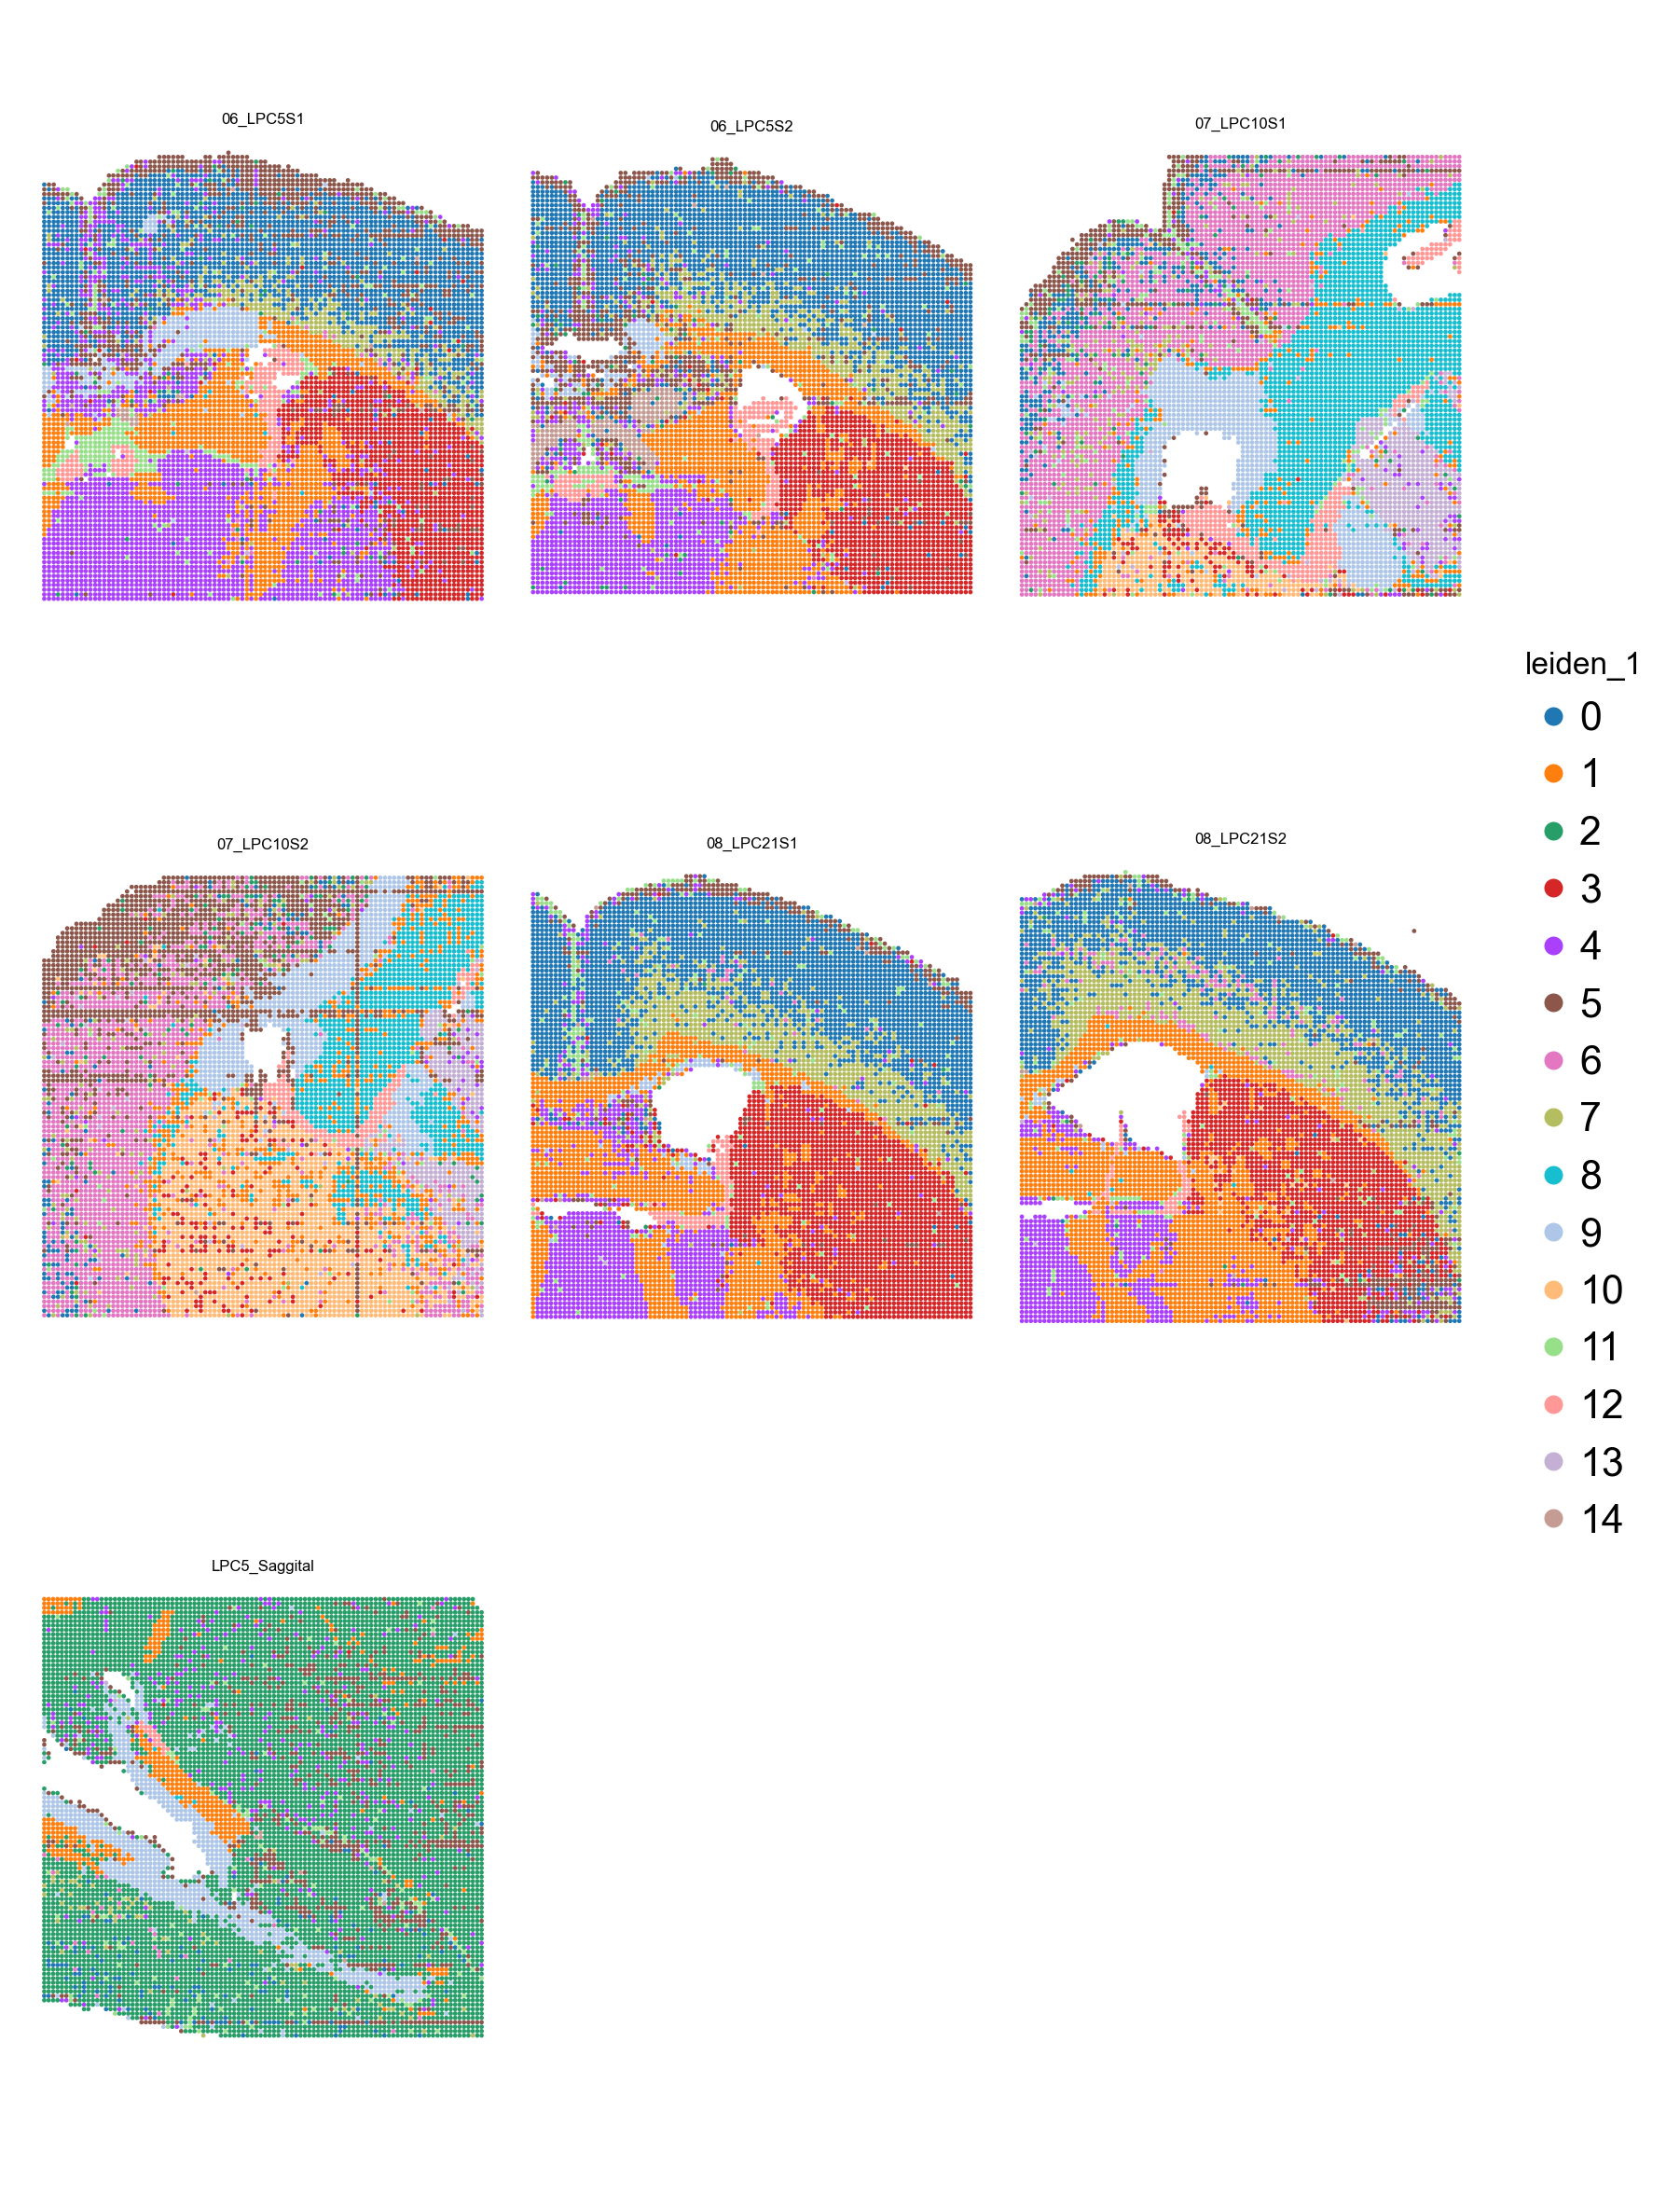

In [8]:
if 'spatial' in rna_pp.obsm:
    plot_spatial_compact_fast(
        rna_pp,
        color='leiden_1',
        groupby='sample_id',
        spot_size=2,
        cols=3,
        height=10,
    )
else:
    print('No spatial coordinates found in rna_pp.obsm["spatial"].')


## Step 6 - Save Outputs


In [9]:
out_dir = Path('data/results')
out_dir.mkdir(parents=True, exist_ok=True)

rna.write_h5ad(out_dir / 'rna_all_samples_raw.h5ad')
rna_pp.write_h5ad(out_dir / 'rna_all_samples_clustered.h5ad')
print('Saved:', out_dir / 'rna_all_samples_raw.h5ad')
print('Saved:', out_dir / 'rna_all_samples_clustered.h5ad')


Saved: data/results/rna_all_samples_raw.h5ad
Saved: data/results/rna_all_samples_clustered.h5ad
